In [1]:
import numpy as np
import xarray as xr
import xesmf as xe
from eofs.xarray import Eof
from eofs.examples import example_data_path
import xgcm
from sklearn import preprocessing
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy import stats

import matplotlib.pyplot as plt
import cartopy.feature as cft
import cartopy.crs as ccrs
import cmocean as cm

from gsw import sigma2, SA_from_SP, p_from_z, rho

import cosima_cookbook as cc
import gcm_filters
import os

import pandas as pd

import cartopy.feature as cfeature

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = UserWarning)
warnings.simplefilter('ignore')

In [2]:
import dask
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43937,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:42071,Total threads: 4
Dashboard: /proxy/33673/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:33633,


In [3]:
start_time, end_time = '2071-01-01', '2100-12-31'
x_min, x_max = -100, 10
y_min, y_max = 10, 75
ρ0 = 1035

var_name = 'beta_v'
color_values = ['blue', 'lightblue', 'black', 'red', 'darkred']
expt_labels = ['-2$\sigma$', '-1$\sigma$', 'CTRL', '+1$\sigma$', '+2$\sigma$']

In [4]:
base_dir = '/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/'
dir_names = ['Monthly_mean_BVB_MOM6-SIS2_negativeNAO-2.0', 
             'Monthly_mean_BVB_MOM6-SIS2_negativeNAO-1.0', 
             'Monthly_mean_BVB_MOM6-SIS2_RYF_control', 
             'Monthly_mean_BVB_MOM6-SIS2_positiveNAO-1.0',
             'Monthly_mean_BVB_MOM6-SIS2_positiveNAO-2.0']

expt = ['mom6-om4-025-RYF-negativeNAO-2.0', 
        'mom6-om4-025-RYF-negativeNAO-1.0', 
        'mom6-om4-025-RYF-control', 
        'mom6-om4-025-RYF-positiveNAO-1.0',
        'mom6-om4-025-RYF-positiveNAO-2.0']

db = '/scratch/x77/db6174/mom6/archive/databases/cc_database_RYF_control.db'
session = cc.database.create_session(db)

In [5]:
x_min_subtropics, x_max_subtropics = -100, 0
y_min_subtropics, y_max_subtropics = 10, 52

In [6]:
def da_north_atlantic_mask_vmo(da):
    ht = cc.querying.getvar(expt[2], 'deptho', session, n = -1)
    ht = grid.interp(ht, 'X', boundary = 'fill')
    ht = grid.interp(ht, 'Y', boundary = 'fill')
    land_mask = ~ht.isnull()
    
    ## create masks out of the above chunks
    south_map = (land_mask.where(land_mask.yq < -34)).fillna(0)
    indo_map1 = (land_mask.where(land_mask.yq < 9).where(land_mask.yq > -34).where(land_mask.xq > -280).where(land_mask.xq < -65)).fillna(0)
    indo_map2 = (land_mask.where(land_mask.yq < 15).where(land_mask.yq > 9).where(land_mask.xq > -280).where(land_mask.xq < -83.7)).fillna(0)
    indo_map3 = (land_mask.where(land_mask.yq < 17).where(land_mask.yq > 15).where(land_mask.xq > -280).where(land_mask.xq < -93.3)).fillna(0)
    indo_map4 = (land_mask.where(land_mask.yq < 85).where(land_mask.yq > 17).where(land_mask.xq > -280).where(land_mask.xq < -99)).fillna(0)
    indo_map5 = (land_mask.where(land_mask.yq < 30.5).where(land_mask.yq > -34).where(land_mask.xq > 25).where(land_mask.xq < 80)).fillna(0)
    
    indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
    indo_sector_mask = indo_sector_map.where(indo_sector_map>0)
    
    atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
    atlantic_sector_map = atlantic_sector_map + south_map
    atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map > 0)
    
    north_atlantic_sector_mask = atlantic_sector_mask.sel(xq = slice(x_min, x_max)).sel(yq = slice(y_min, y_max))
    return da * north_atlantic_sector_mask

In [7]:
umo_2d = cc.querying.getvar(expt[2], 'umo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(xq = slice(1, None)).sel(time = slice(start_time, end_time))
vmo_2d = cc.querying.getvar(expt[2], 'vmo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(yq = slice(1, None)).sel(time = slice(start_time, end_time))

grid_data = xr.merge((umo_2d, vmo_2d))
grid = xgcm.Grid(grid_data, coords={'X': {'center': 'xh', 'right': 'xq'}, 'Y': {'center': 'yh', 'right': 'yq'}}, periodic=['X'])

vmo_2d_itp = grid.interp(vmo_2d, 'X', boundary = 'fill')
vmo_2d_NA = da_north_atlantic_mask_vmo(vmo_2d_itp)

In [8]:
Ψ_NA = vmo_2d_NA.cumsum('xq')/(1e6 * ρ0)
Ψ_NA_tmean = Ψ_NA.mean('time').load()
area_bu = cc.querying.getvar(expt[2], 'areacello_bu', session, frequency = 'static', n = 1)
area_bu_NA = da_north_atlantic_mask_vmo(area_bu)
area_bu_NA = area_bu_NA.where(~np.isnan(Ψ_NA_tmean))

In [9]:
R_earth = 6.378e6
Ω = 7.2921e-5

dyCv = cc.querying.getvar(expt[2], 'dyCv', session, frequency = 'static', n = 1).mean('xh')
geolat_c = cc.querying.getvar(expt[2], 'geolat_c', session, frequency = 'static', n = 1)
geolat_c = geolat_c.where(~np.isnan(Ψ_NA_tmean))

Text(0.5, 1.0, 'Subtropical gyre area integration')

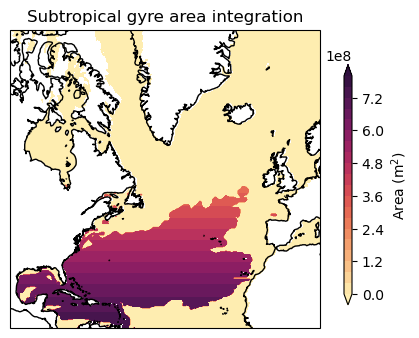

In [10]:
cutoff_contour = 0 ## in Sverdrups

projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), subplot_kw = {'projection': projection})

mask_Ψ = xr.where(Ψ_NA_tmean >= cutoff_contour, 1, 0)
mask_Ψ = xr.where(mask_Ψ.yq <=52, mask_Ψ, 0)
area_subtropics = area_bu_NA * mask_Ψ
p1 = axes.contourf(area_subtropics.xq, area_subtropics.yq, area_subtropics, levels = np.linspace(0, 8e8, 21), 
            cmap = cm.cm.matter, transform = ccrs.PlateCarree(), extend = 'both', color = 'black')

cax = plt.axes([0.96, 0.18, 0.02, 0.6])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Area (m$^2$)', fontsize = 10)

axes.set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
axes.coastlines(resolution = '50m')
axes.set_title('Subtropical gyre area integration')

In [11]:
## One edge case remains, where the function encounters 3 alternating values, like 1, 0, 1.
## Another edge case is when the cutoff contour is close to zero.

def mask_interpolation_transect(Ψ, y_sel, zero_precedes_one, one_precedes_zero, cutoff_contour, old_mask, gyre_type):

    ## This is the original mask
    new_mask = old_mask.copy(deep = True)

    ## We create a streamfunction transect with values greater/smaller than the cutoff transport
    if(gyre_type == 'subtropical'):
        Ψ_cutoff = Ψ.where(Ψ >=cutoff_contour).dropna('xq').load()
    elif(gyre_type == 'subpolar'):
        Ψ_cutoff = Ψ.where(Ψ <=cutoff_contour).dropna('xq').load()

    ## Checking if there are any values to interpolate (true for latitudes where the streamfunction is weaker than the cutoff for all longitudes)
    if(Ψ_cutoff.shape[0] == 0):  
        return old_mask, old_mask
    
    if(zero_precedes_one.shape[0] > 0):
        for i in zero_precedes_one:
            x_west = Ψ.xq[i]
            x_east = Ψ.xq[i+1]
            Ψ_east = Ψ.sel(xq = x_east, method = 'nearest').values
            Ψ_west = Ψ.sel(xq = x_west, method = 'nearest').values

            if (np.isnan(Ψ_west.item()) or np.isnan(Ψ_east.item())):
                continue

            slope = (Ψ_east - Ψ_west)/(x_east - x_west)
            x_mid = x_east - (Ψ_east - cutoff_contour)/slope
            mask_fraction = (x_east - x_mid)/(x_east - x_west)
            new_mask = xr.where(old_mask.xq == x_east, mask_fraction, new_mask)

    if(one_precedes_zero.shape[0] > 0):
        for i in one_precedes_zero:
            x_west = Ψ.xq[i]
            x_east = Ψ.xq[i+1]
            Ψ_east = Ψ.sel(xq = x_east, method = 'nearest').values
            Ψ_west = Ψ.sel(xq = x_west, method = 'nearest').values

            if (np.isnan(Ψ_west.item()) or np.isnan(Ψ_east.item())):
                continue

            slope = (Ψ_east - Ψ_west)/(x_east - x_west)
            x_mid = x_east - (Ψ_east - cutoff_contour)/slope
            mask_fraction = 1 - (x_east - x_mid)/(x_east - x_west)
            new_mask = xr.where(old_mask.xq == x_east, mask_fraction, new_mask)
        
    return old_mask, new_mask

def mask_with_interpolation(Ψ, old_mask_total, cutoff_contour, gyre_type, y_min_bound = None, y_max_bound = None):
           
    for y_sel in Ψ.yq.sel(yq = slice(y_min_bound, y_max_bound)).values:
        Ψ_ysel = Ψ.sel(yq = y_sel, method = 'nearest')
        old_mask = old_mask_total.sel(yq = y_sel, method = 'nearest')

        zero_precedes_one = np.where((old_mask.values[:-1] == 0) & (old_mask.values[1:] == 1))[0]
        one_precedes_zero = np.where((old_mask.values[:-1] == 1) & (old_mask.values[1:] == 0))[0]
        old_mask, new_mask = mask_interpolation_transect(Ψ_ysel, y_sel, zero_precedes_one, one_precedes_zero, cutoff_contour, old_mask, gyre_type)

        if(y_sel == Ψ.yq[0].item()):
            new_mask_total = new_mask
        else:
            new_mask_total = xr.concat([new_mask_total, new_mask], dim = 'yq')

    return new_mask_total

In [12]:
area_bu = cc.querying.getvar(expt[2], 'areacello_bu', session, frequency = 'static', n = 1)
area_bu = da_north_atlantic_mask_vmo(area_bu)
area_bu = area_bu.where(~np.isnan(vmo_2d_itp.isel(time = 0))).fillna(0)

def gyre_percentile_subtropics(expt_val, quantile):
    umo_2d = cc.querying.getvar(expt_val, 'umo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(xq = slice(1, None)).sel(time = slice(start_time, end_time))
    vmo_2d = cc.querying.getvar(expt_val, 'vmo_2d', session, frequency = '1 monthly', start_time = start_time, 
                                end_time = end_time, chunks = {}).isel(yq = slice(1, None)).sel(time = slice(start_time, end_time))
    
    grid_data = xr.merge((umo_2d, vmo_2d))
    grid = xgcm.Grid(grid_data, coords={'X': {'center': 'xh', 'right': 'xq'}, 'Y': {'center': 'yh', 'right': 'yq'}}, periodic=['X'])
    
    vmo_2d_itp = grid.interp(vmo_2d, 'X', boundary = 'fill')
    vmo_2d_NA = da_north_atlantic_mask_vmo(vmo_2d_itp)
    Ψ_NA = vmo_2d_NA.cumsum('xq')/(1e6 * ρ0)
    Ψ_NA_tmean = Ψ_NA.mean('time')
    Ψ_NA_tmean = Ψ_NA_tmean.chunk(chunks = {'xq':-1, 'yq':-1})
    Ψ_NA_tmean = Ψ_NA_tmean.sel(xq = slice(x_min_subtropics, x_max_subtropics)).sel(yq = slice(y_min_subtropics, y_max_subtropics))
    Ψ_gyre = Ψ_NA_tmean.weighted(area_bu).quantile(quantile, dim = {"yq", "xq"})

    return Ψ_NA_tmean, Ψ_gyre

In [13]:
mask_Ψ.load()
cutoff_whole = 0
mask_Ψ_improved = mask_with_interpolation(Ψ_NA_tmean, mask_Ψ, cutoff_whole, gyre_type = 'subtropical')

In [14]:
var_list = ['beta_v', 'BPT', 'curl_NL', 'curl_taus', 'curl_taub', 'curl_diff', 'mass_flux', 'curl_dudt', 'eta_dt']
expt_labels = ['-2$\sigma$', '-1$\sigma$', 'CTRL', '+1$\sigma$', '+2$\sigma$']
color_values = ['blue', 'lightblue', 'black', 'red', 'darkred']

In [15]:
def find_last_one(arr):
    return np.array([np.max(np.where(row!=0)) if np.any(row!=0) else -1 for row in arr])
    
def masks_separation_gyre_strength(mask_western_gyre_improved, mask_Ψ_improved):

    data_np = mask_western_gyre_improved.values
    last_ones = find_last_one(mask_western_gyre_improved.values)
    updated_data_np = data_np.copy()
    updated_data_np2 = data_np.copy()
    for i, last_idx in enumerate(last_ones):
        if last_idx == -1:  # If there is at least one '1' in the row
            updated_data_np2[i, :] = 1
        else:
            updated_data_np[i, :last_idx] = 1
            updated_data_np2[i, :last_idx] = 0
            updated_data_np2[i, last_idx] = 1 - data_np[i, last_idx]
            updated_data_np2[i, last_idx + 1:] = 1

    mask_GS_west = xr.DataArray(updated_data_np, dims = ["yq", "xq"], coords = 
                                [mask_western_gyre_improved.yq, mask_western_gyre_improved.xq])
    mask_GS_east = xr.DataArray(updated_data_np2, dims = ["yq", "xq"], coords = 
                                [mask_western_gyre_improved.yq, mask_western_gyre_improved.xq])

    mask_GS_west = xr.where((mask_Ψ_improved + mask_GS_west) > 1, mask_Ψ_improved, 0)
    mask_GS_east = mask_Ψ_improved - mask_GS_west

    return mask_GS_west, mask_GS_east

In [16]:
expt_labels = ['-2$\sigma$', '-1$\sigma$', 'CTRL', '+1$\sigma$', '+2$\sigma$']
color_values = ['blue', 'lightblue', 'black', 'red', 'darkred']
var_list_subset = ['BPT', 'curl_NL', 'curl_taus', 'curl_taub', 'curl_diff', 'mass_flux', 'curl_dudt', 'eta_dt']
gyre_strength_comparison = np.zeros(5)
expt_name = dir_names[2]

array_western = np.zeros(9)
array_eastern = np.zeros(9)
Ψ_NA_tmean, Ψ_gyre_strength = gyre_percentile_subtropics(expt[2], 0.95)
Ψ_NA_tmean.load()
Ψ_gyre_strength.load()
mask_Ψ = xr.where(Ψ_NA_tmean >= cutoff_contour, 1, 0)
mask_Ψ = xr.where(mask_Ψ.yq <=52, mask_Ψ, 0).load()
mask_Ψ_improved = mask_with_interpolation(Ψ_NA_tmean, mask_Ψ, cutoff_contour, gyre_type = 'subtropical').load()
mask_western_gyre = xr.where(Ψ_NA_tmean >=Ψ_gyre_strength, 1, 0).load()
mask_western_gyre_improved = mask_with_interpolation(Ψ_NA_tmean, mask_western_gyre, Ψ_gyre_strength, gyre_type = 'subtropical').load()
mask_interior_improved = (mask_Ψ_improved - mask_western_gyre_improved)
western_mask_subtropics, eastern_mask_subtropics = masks_separation_gyre_strength(mask_western_gyre_improved, mask_Ψ_improved)

vort_BPT = xr.open_dataset(base_dir + dir_names[2] + '/bvb.nc').BPT.sel(time = slice(start_time, end_time))

β = 2 * Ω * np.cos(geolat_c * np.pi /180.)/R_earth
β = (xr.where(western_mask_subtropics == 0, np.nan, 1) * β).mean('xq')

bvb_ds = xr.open_dataset(base_dir + dir_names[2] + '/bvb.nc').sel(time = slice(start_time, end_time))
for i, var_name in enumerate(var_list_subset):
    var = bvb_ds[var_name]
    var = xr.where(np.isnan(vort_BPT.isel(time = 0)), np.nan, var)
    var = (var * eastern_mask_subtropics * area_bu_NA).sum('xq').sum('yq').mean('time')
    var = var/(β * dyCv).sum('yq')/1e6
    array_eastern[i] = var.values

    var = bvb_ds[var_name]
    var = xr.where(np.isnan(vort_BPT.isel(time = 0)), np.nan, var)
    var = (var * western_mask_subtropics * area_bu_NA).sum('xq').sum('yq').mean('time')
    var = var/(β * dyCv).sum('yq')/1e6
    array_western[i] = var.values

array_western[8] = np.sign(np.sum(array_western)) * Ψ_gyre_strength.values - np.sum(array_western)
array_eastern[8] = np.sign(np.sum(array_eastern)) * Ψ_gyre_strength.values - np.sum(array_eastern)

In [17]:
df_subtropics = pd.DataFrame({
    r'$\frac{J(p_b, H)}{\rho_0}$': [array_western[0], array_eastern[0]], 
    r'$\hat{z} \cdot \nabla \times \mathcal{A}$': [array_western[1], array_eastern[1]], 
    r'$\hat{z} \cdot \frac{\nabla \times \tau_s}{\rho_0}$': [array_western[2], array_eastern[2]], 
    r'$-\hat{z} \cdot \frac{\nabla \times \tau_b}{\rho_0}$': [array_western[3], array_eastern[3]],
    r'$\hat{z} \cdot \nabla \times \mathcal{B}$': [array_western[4], array_eastern[4]],
    r'$- f \frac{Q_m}{\rho_0}$': [array_western[5], array_eastern[5]],
    r'$- \hat{z} \cdot (\nabla \times \mathcal{V}_t)$': [array_western[6], array_eastern[6]],
    r'$f \frac{\partial \eta}{\partial t}$': [array_western[7], array_eastern[7]],
    'Residual': [array_western[8], array_eastern[8]]
}, index=['WBC', 'Interior'])

In [18]:
df_subtropics

,"$\frac{J(p_b, H)}{\rho_0}$",$\hat{z} \cdot \nabla \times \mathcal{A}$,$\hat{z} \cdot \frac{\nabla \times \tau_s}{\rho_0}$,$-\hat{z} \cdot \frac{\nabla \times \tau_b}{\rho_0}$,$\hat{z} \cdot \nabla \times \mathcal{B}$,$- f \frac{Q_m}{\rho_0}$,$- \hat{z} \cdot (\nabla \times \mathcal{V}_t)$,$f \frac{\partial \eta}{\partial t}$,Residual
WBC,15.774517,-2.325960,-2.256178,4.685928,1.553645,0.085499,-0.187971,-0.000085,1.846301
Interior,-6.777090,0.894703,-14.031157,1.165966,0.351891,0.279839,0.073751,-0.000936,-1.132664


## Subpolar gyre

In [19]:
x_min_subpolar, x_max_subpolar = -70, -8
y_min_subpolar, y_max_subpolar = 40, 67

In [20]:
umo_2d = cc.querying.getvar(expt[2], 'umo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(xq = slice(1, None)).sel(time = slice(start_time, end_time))
vmo_2d = cc.querying.getvar(expt[2], 'vmo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(yq = slice(1, None)).sel(time = slice(start_time, end_time))

grid_data = xr.merge((umo_2d, vmo_2d))
grid = xgcm.Grid(grid_data, coords={'X': {'center': 'xh', 'right': 'xq'}, 'Y': {'center': 'yh', 'right': 'yq'}}, periodic=['X'])

vmo_2d_itp = grid.interp(vmo_2d, 'X', boundary = 'fill')
vmo_2d_NA = da_north_atlantic_mask_vmo(vmo_2d_itp)

In [21]:
Ψ_NA = vmo_2d_NA.cumsum('xq')/(1e6 * ρ0)

In [22]:
Ψ_NA_tmean = Ψ_NA.mean('time').load()
area_bu = cc.querying.getvar(expt[2], 'areacello_bu', session, frequency = 'static', n = 1)
area_bu_NA = da_north_atlantic_mask_vmo(area_bu)
area_bu_NA = area_bu_NA.where(~np.isnan(Ψ_NA_tmean))

Text(0.5, 1.0, 'Subpolar gyre area integration')

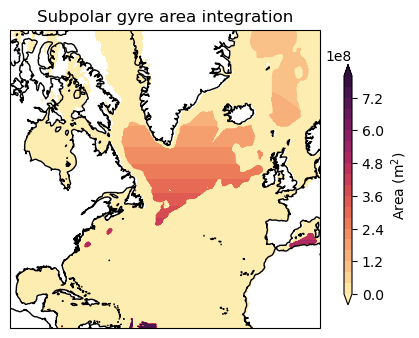

In [23]:
cutoff_contour = -10 ## in Sverdrups

projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), subplot_kw = {'projection': projection})

mask_neg10 = xr.where(Ψ_NA_tmean <= cutoff_contour, 1, 0)
area_subpolar = area_bu_NA * mask_neg10
p1 = axes.contourf(area_subpolar.xq, area_subpolar.yq, area_subpolar, levels = np.linspace(0, 8e8, 21), 
            cmap = cm.cm.matter, transform = ccrs.PlateCarree(), extend = 'both', color = 'black')

cax = plt.axes([0.96, 0.18, 0.02, 0.6])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Area (m$^2$)', fontsize = 10)

axes.set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
axes.coastlines(resolution = '50m')
axes.set_title('Subpolar gyre area integration')

In [24]:
mask_neg10_subset = mask_neg10.sel(xq = slice(x_min_subpolar, x_max_subpolar)).sel(yq = slice(y_min_subpolar, y_max_subpolar)).load()
Ψ_NA_tmean_subset = Ψ_NA_tmean.sel(xq = slice(x_min_subpolar, x_max_subpolar)).sel(yq = slice(y_min_subpolar, y_max_subpolar)).load()

cutoff_whole = -10
mask_neg10_improved = mask_with_interpolation(Ψ_NA_tmean_subset, mask_neg10_subset, cutoff_whole, 
                                              'subpolar', y_min_bound = None, y_max_bound = None)

In [25]:
area_bu = cc.querying.getvar(expt[2], 'areacello_bu', session, frequency = 'static', n = 1)
area_bu = da_north_atlantic_mask_vmo(area_bu)
area_bu = area_bu.where(~np.isnan(vmo_2d_itp.isel(time = 0))).fillna(0)

def gyre_percentile_subpolar(expt_val, quantile):
    umo_2d = cc.querying.getvar(expt_val, 'umo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(xq = slice(1, None)).sel(time = slice(start_time, end_time))
    vmo_2d = cc.querying.getvar(expt_val, 'vmo_2d', session, frequency = '1 monthly', start_time = start_time, 
                                end_time = end_time, chunks = {}).isel(yq = slice(1, None)).sel(time = slice(start_time, end_time))
    
    grid_data = xr.merge((umo_2d, vmo_2d))
    grid = xgcm.Grid(grid_data, coords={'X': {'center': 'xh', 'right': 'xq'}, 'Y': {'center': 'yh', 'right': 'yq'}}, periodic=['X'])
    
    vmo_2d_itp = grid.interp(vmo_2d, 'X', boundary = 'fill')
    vmo_2d_NA = da_north_atlantic_mask_vmo(vmo_2d_itp)
    Ψ_NA = vmo_2d_NA.cumsum('xq')/(1e6 * ρ0)
    Ψ_NA_tmean = Ψ_NA.mean('time')
    Ψ_NA_tmean = Ψ_NA_tmean.chunk(chunks = {'xq':-1, 'yq':-1})
    Ψ_NA_tmean = Ψ_NA_tmean.sel(xq = slice(x_min_subpolar, x_max_subpolar)).sel(yq = slice(y_min_subpolar, y_max_subpolar))
    Ψ_gyre = Ψ_NA_tmean.weighted(area_bu).quantile(quantile, dim = {"yq", "xq"})

    return Ψ_NA_tmean, Ψ_gyre

In [26]:
Ψ_NA_tmean, Ψ_gyre_strength = gyre_percentile_subpolar(expt[2], 0.05)
Ψ_NA_tmean.load()
Ψ_gyre_strength.load()
mask_Ψ = xr.where(Ψ_NA_tmean <= cutoff_contour, 1, 0)
mask_Ψ = xr.where(mask_Ψ.yq >= y_min_subpolar, mask_Ψ, 0)
mask_Ψ = xr.where(mask_Ψ.xq <= x_max_subpolar, mask_Ψ, 0).load()
mask_Ψ_improved = mask_with_interpolation(Ψ_NA_tmean, mask_Ψ, cutoff_contour, gyre_type = 'subpolar').load()
mask_western_gyre = xr.where(Ψ_NA_tmean <= Ψ_gyre_strength, 1, 0).load()
mask_western_gyre_improved = mask_with_interpolation(Ψ_NA_tmean, mask_western_gyre, Ψ_gyre_strength, gyre_type = 'subpolar').load()
mask_interior_improved = (mask_Ψ_improved - mask_western_gyre_improved)
western_mask_subpolar, eastern_mask_subpolar = masks_separation_gyre_strength(mask_western_gyre_improved, mask_Ψ_improved)

vort_BPT = xr.open_dataset(base_dir + dir_names[2] + '/bvb.nc').BPT.sel(time = slice(start_time, end_time))

β = 2 * Ω * np.cos(geolat_c * np.pi /180.)/R_earth
β = (xr.where(western_mask_subpolar == 0, np.nan, 1) * β).mean('xq')

array_western = np.zeros(9)
array_eastern = np.zeros(9)

bvb_ds = xr.open_dataset(base_dir + dir_names[2] + '/bvb.nc').sel(time = slice(start_time, end_time))
for i, var_name in enumerate(var_list_subset):
    var = bvb_ds[var_name]
    var = xr.where(np.isnan(vort_BPT.isel(time = 0)), np.nan, var)
    var = (var * eastern_mask_subpolar * area_bu_NA).sum('xq').sum('yq').mean('time')
    var = var/(β * dyCv).sum('yq')/1e6
    array_eastern[i] = var.values

    var = bvb_ds[var_name]
    var = xr.where(np.isnan(vort_BPT.isel(time = 0)), np.nan, var)
    var = (var * western_mask_subpolar * area_bu_NA).sum('xq').sum('yq').mean('time')
    var = var/(β * dyCv).sum('yq')/1e6
    array_western[i] = var.values

array_western[8] = abs(Ψ_gyre_strength.values) - abs(np.sum(array_western)) - abs(cutoff_contour)
array_eastern[8] = abs(Ψ_gyre_strength.values) - abs(np.sum(array_eastern)) - abs(cutoff_contour)

In [27]:
df_subpolar = pd.DataFrame({
    r'$\frac{J(p_b, H)}{\rho_0}$': [array_western[0], array_eastern[0]], 
    r'$\hat{z} \cdot \nabla \times \mathcal{A}$': [array_western[1], array_eastern[1]], 
    r'$\hat{z} \cdot \frac{\nabla \times \tau_s}{\rho_0}$': [array_western[2], array_eastern[2]], 
    r'$-\hat{z} \cdot \frac{\nabla \times \tau_b}{\rho_0}$': [array_western[3], array_eastern[3]],
    r'$\hat{z} \cdot \nabla \times \mathcal{B}$': [array_western[4], array_eastern[4]],
    r'$- f \frac{Q_m}{\rho_0}$': [array_western[5], array_eastern[5]],
    r'$- \hat{z} \cdot (\nabla \times \mathcal{V}_t)$': [array_western[6], array_eastern[6]],
    r'$f \frac{\partial \eta}{\partial t}$': [array_western[7], array_eastern[7]],
    'Residual': [-array_western[8], array_eastern[8]] # Remember to add a negative sign in western case if all other terms are positive, and vice-versa
}, index=['WBC', 'Interior'])

In [28]:
df_subpolar

,"$\frac{J(p_b, H)}{\rho_0}$",$\hat{z} \cdot \nabla \times \mathcal{A}$,$\hat{z} \cdot \frac{\nabla \times \tau_s}{\rho_0}$,$-\hat{z} \cdot \frac{\nabla \times \tau_b}{\rho_0}$,$\hat{z} \cdot \nabla \times \mathcal{B}$,$- f \frac{Q_m}{\rho_0}$,$- \hat{z} \cdot (\nabla \times \mathcal{V}_t)$,$f \frac{\partial \eta}{\partial t}$,Residual
WBC,31.736173,-16.810620,1.630028,-30.445758,-15.898967,-0.096815,1.523673,-0.000574,-1.249339
Interior,57.435294,18.186012,15.711119,-21.550151,-42.013466,-0.212765,0.809329,-0.001166,1.247994


In [27]:
western_mask_subtropics2 = xr.where(np.isnan(vort_BPT.sel(xq = slice(x_min_subtropics, x_max_subtropics)).sel(yq = slice(y_min_subtropics, y_max_subtropics)).isel(
    time = 0)), np.nan, western_mask_subtropics)
eastern_mask_subtropics2 = xr.where(np.isnan(vort_BPT.sel(xq = slice(x_min_subtropics, x_max_subtropics)).sel(yq = slice(y_min_subtropics, y_max_subtropics)).isel(
    time = 0)), np.nan, eastern_mask_subtropics)

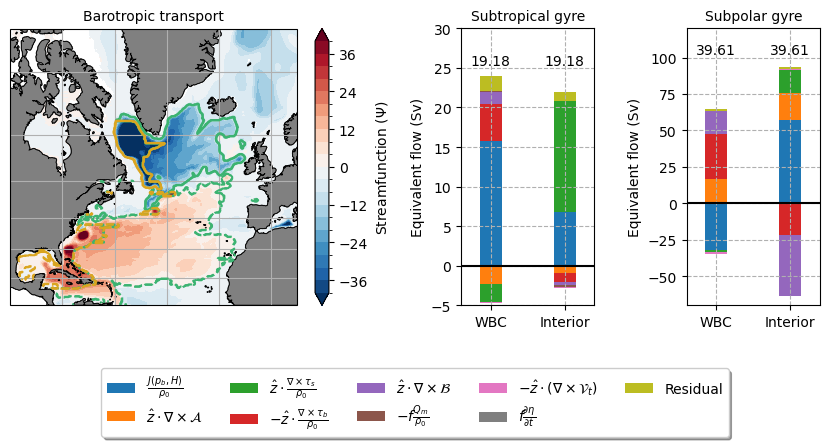

In [28]:
fig = plt.figure()
fig.set_figheight(2.5 * 1.4)
fig.set_figwidth(6 * 1.4)

projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
ax1 = plt.subplot2grid(shape = (1, 4), loc = (0, 0), rowspan = 1, colspan = 2, projection = projection)

Ψ_NA = vmo_2d_NA.cumsum('xq')/(1e6 * ρ0)
Ψ_NA_tmean = Ψ_NA.mean('time')
Ψ_NA_tmean = xr.where(np.isnan(vmo_2d_NA.isel(time = 0)), np.nan, Ψ_NA_tmean).rename('Streamfunction ($\Psi$)').load()

land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='gray', linewidth=0.5)
ax1.coastlines(resolution = '50m')
ax1.add_feature(land_50m)
gl = ax1.gridlines(draw_labels = False)

Ψ_NA_tmean.plot.contourf(ax = ax1, x = 'xq', y = 'yq', cmap = 'RdBu_r', transform = ccrs.PlateCarree(), 
                         levels = np.linspace(-40, 40, 21), add_colorbar = True, rasterized = True, zorder = -20)
ax1.contour(eastern_mask_subpolar.xq, eastern_mask_subpolar.yq, eastern_mask_subpolar, transform = ccrs.PlateCarree(), levels = 1, colors = 'mediumseagreen', lw = 0.5)
ax1.contour(western_mask_subpolar.xq, western_mask_subpolar.yq, western_mask_subpolar, transform = ccrs.PlateCarree(), levels = 1, colors = 'goldenrod', lw = 0.5)

ax1.contour(eastern_mask_subtropics2.xq, eastern_mask_subtropics2.yq, eastern_mask_subtropics2, transform = ccrs.PlateCarree(), levels = 1, colors = 'mediumseagreen', lw = 0.5, linestyles = '--')
ax1.contour(western_mask_subtropics2.xq, western_mask_subtropics2.yq, western_mask_subtropics2, transform = ccrs.PlateCarree(), levels = 1, colors = 'goldenrod', lw = 0.5, linestyles = '--')

ax1.set_title('Barotropic transport', fontsize = 10)

ax1 = plt.subplot2grid(shape = (1, 4), loc = (0, 2), rowspan = 1, colspan = 1)

df_subtropics.plot(kind = "bar", stacked = True, width = 0.3, ax = ax1)
plt.grid(True, ls = '--')
plt.ylim([-5, 30])
plt.axhline(0, color = 'black')
plt.xticks(rotation = 0)

totals = df_subtropics.sum(axis=1)

# Add the sum as text at the top of each bar
for i, total in enumerate(totals):
    plt.text(i, 25, str(round(total, 2)), ha='center', va='bottom')

ax1.legend().set_visible(False)
ax1.set_title('Subtropical gyre', fontsize = 10)
ax1.set_ylabel('Equivalent flow (Sv)')

ax1 = plt.subplot2grid(shape = (1, 4), loc = (0, 3), rowspan = 1, colspan = 1)

df_subpolar.plot(kind = "bar", stacked = True, width = 0.3, ax = ax1)
plt.grid(True, ls = '--')
plt.ylim([-70, 120])
plt.axhline(0, color = 'black')
plt.xticks(rotation = 0)

totals = df_subpolar.sum(axis=1)

# Add the sum as text at the top of each bar
for i, total in enumerate(totals):
    plt.text(i, 100, str(round(total + abs(cutoff_contour), 2)), ha='center', va='bottom')

ax1.legend().set_visible(False)
ax1.set_title('Subpolar gyre', fontsize = 10)
ax1.set_ylabel('Equivalent flow (Sv)')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc = 'upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol = 5, fontsize = 10)

fig.tight_layout()

plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/Draft_figures/Control-budget.pdf', bbox_inches = 'tight', 
            dpi = 300, transparent=True)

In [33]:
v1 = xr.open_dataset(base_dir + expt_name + '/141-180/' + var_list_subset2[0] + '_filtered2.nc').__xarray_dataarray_variable__
v2 = xr.open_dataset(base_dir + expt_name + '/181-200/' + var_list_subset2[0] + '_filtered.nc').__xarray_dataarray_variable__
beta_v = xr.concat([v1, v2], dim = 'time').sel(time = slice('2071-01-01', '2100-12-31')).mean('time').sel(xq = slice(x_min_subtropics, x_max_subtropics)).sel(yq = slice(y_min_subtropics, y_max_subtropics)).sel(filter_scale = 1).load()

v1 = xr.open_dataset(base_dir + expt_name + '/141-180/' + var_list_subset2[1] + '_filtered2.nc').__xarray_dataarray_variable__
v2 = xr.open_dataset(base_dir + expt_name + '/181-200/' + var_list_subset2[1] + '_filtered.nc').__xarray_dataarray_variable__
BPT = xr.concat([v1, v2], dim = 'time').sel(time = slice('2071-01-01', '2100-12-31')).mean('time').sel(xq = slice(x_min_subtropics, x_max_subtropics)).sel(yq = slice(y_min_subtropics, y_max_subtropics)).sel(filter_scale = 1).load()

v1 = xr.open_dataset(base_dir + expt_name + '/141-180/' + var_list_subset2[2] + '_filtered2.nc').__xarray_dataarray_variable__
v2 = xr.open_dataset(base_dir + expt_name + '/181-200/' + var_list_subset2[2] + '_filtered.nc').__xarray_dataarray_variable__
curl_taus = xr.concat([v1, v2], dim = 'time').sel(time = slice('2071-01-01', '2100-12-31')).mean('time').sel(xq = slice(x_min_subtropics, x_max_subtropics)).sel(yq = slice(y_min_subtropics, y_max_subtropics)).sel(filter_scale = 1).load()

v1 = xr.open_dataset(base_dir + expt_name + '/141-180/' + var_list_subset2[3] + '_filtered2.nc').__xarray_dataarray_variable__
v2 = xr.open_dataset(base_dir + expt_name + '/181-200/' + var_list_subset2[3] + '_filtered.nc').__xarray_dataarray_variable__
curl_taub = xr.concat([v1, v2], dim = 'time').sel(time = slice('2071-01-01', '2100-12-31')).mean('time').sel(xq = slice(x_min_subtropics, x_max_subtropics)).sel(yq = slice(y_min_subtropics, y_max_subtropics)).sel(filter_scale = 1).load()

v1 = xr.open_dataset(base_dir + expt_name + '/141-180/' + var_list_subset2[4] + '_filtered2.nc').__xarray_dataarray_variable__
v2 = xr.open_dataset(base_dir + expt_name + '/181-200/' + var_list_subset2[4] + '_filtered.nc').__xarray_dataarray_variable__
curl_NL = xr.concat([v1, v2], dim = 'time').sel(time = slice('2071-01-01', '2100-12-31')).mean('time').sel(xq = slice(x_min_subtropics, x_max_subtropics)).sel(yq = slice(y_min_subtropics, y_max_subtropics)).sel(filter_scale = 1).load()

v1 = xr.open_dataset(base_dir + expt_name + '/141-180/' + var_list_subset2[5] + '_filtered2.nc').__xarray_dataarray_variable__
v2 = xr.open_dataset(base_dir + expt_name + '/181-200/' + var_list_subset2[5] + '_filtered.nc').__xarray_dataarray_variable__
curl_diff = xr.concat([v1, v2], dim = 'time').sel(time = slice('2071-01-01', '2100-12-31')).mean('time').sel(xq = slice(x_min_subtropics, x_max_subtropics)).sel(yq = slice(y_min_subtropics, y_max_subtropics)).sel(filter_scale = 1).load()

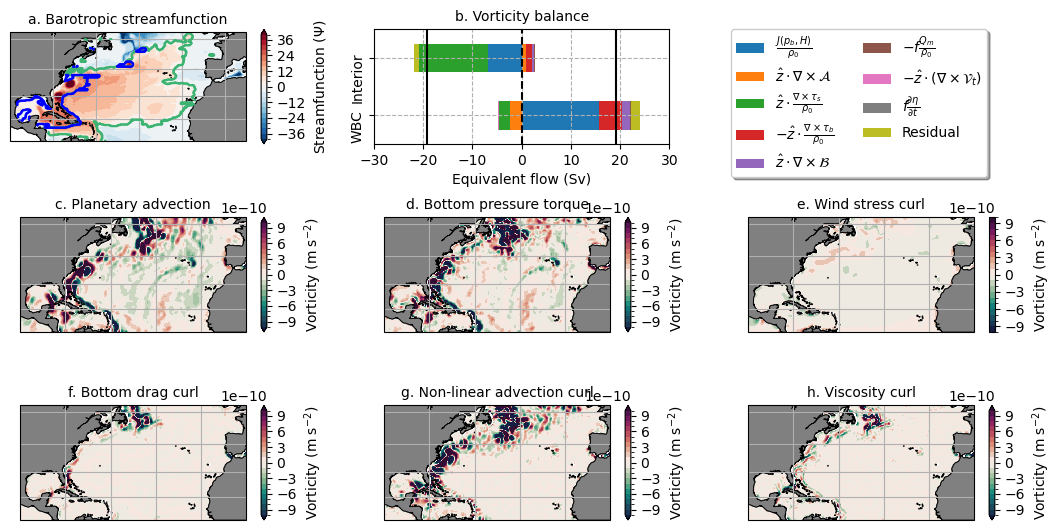

In [59]:
fig = plt.figure()
fig.set_figheight(3 * 1.8)
fig.set_figwidth(6 * 1.8)

projection = ccrs.Mercator(central_longitude = (x_max_subtropics + x_min_subtropics)/2, min_latitude = y_min_subtropics, 
                           max_latitude = y_max_subtropics)
ax1 = plt.subplot2grid(shape = (3, 3), loc = (0, 0), rowspan = 1, colspan = 1, projection = projection)

Ψ_NA = vmo_2d_NA.cumsum('xq')/(1e6 * ρ0)
Ψ_NA_tmean = Ψ_NA.mean('time')
Ψ_NA_tmean = xr.where(np.isnan(vmo_2d_NA.isel(time = 0)), np.nan, Ψ_NA_tmean).rename('Streamfunction ($\Psi$)').load()

land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='gray', linewidth=0.5)
ax1.coastlines(resolution = '50m')
ax1.add_feature(land_50m)
gl = ax1.gridlines(draw_labels = False)

Ψ_NA_tmean.plot.contourf(ax = ax1, x = 'xq', y = 'yq', cmap = 'RdBu_r', transform = ccrs.PlateCarree(), 
                         levels = np.linspace(-40, 40, 21), add_colorbar = True, rasterized = True, zorder = -20)

ax1.contour(eastern_mask_subtropics.xq, eastern_mask_subtropics.yq, eastern_mask_subtropics, transform = ccrs.PlateCarree(), 
            levels = 1, colors = 'mediumseagreen', lw = 0.5)
ax1.contour(western_mask_subtropics.xq, western_mask_subtropics.yq, western_mask_subtropics, transform = ccrs.PlateCarree(), 
            levels = 1, colors = 'blue', lw = 0.5)

ax1.set_title('a. Barotropic streamfunction', fontsize = 10)

ax1 = plt.subplot2grid(shape = (3, 3), loc = (0, 1), rowspan = 1, colspan = 1)

df_subtropics.plot(kind = "barh", stacked = True, ax = ax1)
plt.grid(True, ls = '--')
plt.xlim([-100, 100])
plt.axvline(0, color = 'black', ls = '--')
plt.yticks(rotation = 90)

totals = df_subtropics.sum(axis=1)

plt.axvline(totals.max(), color = 'black')
plt.axvline(totals.min(), color = 'black')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc = 'upper center', bbox_to_anchor = (0.8, 0.95),
          fancybox = True, shadow = True, ncol = 2, fontsize = 10)

ax1.legend().set_visible(False)
ax1.set_title('b. Vorticity balance', fontsize = 10)
ax1.set_xlabel('Equivalent flow (Sv)')

ax1 = plt.subplot2grid(shape = (3, 3), loc = (1, 0), rowspan = 1, colspan = 1, projection = projection)
ax1.coastlines(resolution = '50m')
ax1.add_feature(land_50m)
gl = ax1.gridlines(draw_labels = False)
beta_v.rename('Vorticity (m s$^{-2}$)').plot(ax = ax1, x = 'xq', y = 'yq', cmap = cm.cm.curl, transform = ccrs.PlateCarree(), 
                                 levels = np.linspace(-1e-9, 1e-9, 21), add_colorbar = True, rasterized = True, zorder = -20)
#ax1.contour(eastern_mask_subtropics2.xq, eastern_mask_subtropics2.yq, eastern_mask_subtropics2, transform = ccrs.PlateCarree(), 
#            levels = 1, colors = 'mediumseagreen', lw = 0.5)
#ax1.contour(western_mask_subtropics2.xq, western_mask_subtropics2.yq, western_mask_subtropics2, transform = ccrs.PlateCarree(), 
#            levels = 1, colors = 'blue', lw = 0.5)
ax1.set_title('c. Planetary advection', fontsize = 10)

ax1 = plt.subplot2grid(shape = (3, 3), loc = (1, 1), rowspan = 1, colspan = 1, projection = projection)
ax1.coastlines(resolution = '50m')
ax1.add_feature(land_50m)
gl = ax1.gridlines(draw_labels = False)
BPT.rename('Vorticity (m s$^{-2}$)').plot(ax = ax1, x = 'xq', y = 'yq', cmap = cm.cm.curl, transform = ccrs.PlateCarree(), 
                                 levels = np.linspace(-1e-9, 1e-9, 21), add_colorbar = True, rasterized = True, zorder = -20)
#ax1.contour(eastern_mask_subtropics2.xq, eastern_mask_subtropics2.yq, eastern_mask_subtropics2, transform = ccrs.PlateCarree(), 
#            levels = 1, colors = 'mediumseagreen', lw = 0.5)
#ax1.contour(western_mask_subtropics2.xq, western_mask_subtropics2.yq, western_mask_subtropics2, transform = ccrs.PlateCarree(), 
#            levels = 1, colors = 'blue', lw = 0.5)
ax1.set_title('d. Bottom pressure torque', fontsize = 10)

ax1 = plt.subplot2grid(shape = (3, 3), loc = (1, 2), rowspan = 1, colspan = 1, projection = projection)
ax1.coastlines(resolution = '50m')
ax1.add_feature(land_50m)
gl = ax1.gridlines(draw_labels = False)
curl_taus.rename('Vorticity (m s$^{-2}$)').plot(ax = ax1, x = 'xq', y = 'yq', cmap = cm.cm.curl, transform = ccrs.PlateCarree(), 
                                 levels = np.linspace(-1e-9, 1e-9, 21), add_colorbar = True, rasterized = True, zorder = -20)
#ax1.contour(eastern_mask_subtropics2.xq, eastern_mask_subtropics2.yq, eastern_mask_subtropics2, transform = ccrs.PlateCarree(), 
#            levels = 1, colors = 'mediumseagreen', lw = 0.5)
#ax1.contour(western_mask_subtropics2.xq, western_mask_subtropics2.yq, western_mask_subtropics2, transform = ccrs.PlateCarree(), 
#            levels = 1, colors = 'blue', lw = 0.5)
ax1.set_title('e. Wind stress curl', fontsize = 10)

ax1 = plt.subplot2grid(shape = (3, 3), loc = (2, 0), rowspan = 1, colspan = 1, projection = projection)
ax1.coastlines(resolution = '50m')
ax1.add_feature(land_50m)
gl = ax1.gridlines(draw_labels = False)
curl_taub.rename('Vorticity (m s$^{-2}$)').plot(ax = ax1, x = 'xq', y = 'yq', cmap = cm.cm.curl, transform = ccrs.PlateCarree(), 
                                 levels = np.linspace(-1e-9, 1e-9, 21), add_colorbar = True, rasterized = True, zorder = -20)
#ax1.contour(eastern_mask_subtropics2.xq, eastern_mask_subtropics2.yq, eastern_mask_subtropics2, transform = ccrs.PlateCarree(), 
#            levels = 1, colors = 'mediumseagreen', lw = 0.5)
#ax1.contour(western_mask_subtropics2.xq, western_mask_subtropics2.yq, western_mask_subtropics2, transform = ccrs.PlateCarree(), 
#            levels = 1, colors = 'blue', lw = 0.5)
ax1.set_title('f. Bottom drag curl', fontsize = 10)

ax1 = plt.subplot2grid(shape = (3, 3), loc = (2, 1), rowspan = 1, colspan = 1, projection = projection)
ax1.coastlines(resolution = '50m')
ax1.add_feature(land_50m)
gl = ax1.gridlines(draw_labels = False)
curl_NL.rename('Vorticity (m s$^{-2}$)').plot(ax = ax1, x = 'xq', y = 'yq', cmap = cm.cm.curl, transform = ccrs.PlateCarree(), 
                                 levels = np.linspace(-1e-9, 1e-9, 21), add_colorbar = True, rasterized = True, zorder = -20)
#ax1.contour(eastern_mask_subtropics2.xq, eastern_mask_subtropics2.yq, eastern_mask_subtropics2, transform = ccrs.PlateCarree(), 
#            levels = 1, colors = 'mediumseagreen', lw = 0.5)
#ax1.contour(western_mask_subtropics2.xq, western_mask_subtropics2.yq, western_mask_subtropics2, transform = ccrs.PlateCarree(), 
#            levels = 1, colors = 'blue', lw = 0.5)
ax1.set_title('g. Non-linear advection curl', fontsize = 10)

ax1 = plt.subplot2grid(shape = (3, 3), loc = (2, 2), rowspan = 1, colspan = 1, projection = projection)
ax1.coastlines(resolution = '50m')
ax1.add_feature(land_50m)
gl = ax1.gridlines(draw_labels = False)
curl_diff.rename('Vorticity (m s$^{-2}$)').plot(ax = ax1, x = 'xq', y = 'yq', cmap = cm.cm.curl, transform = ccrs.PlateCarree(), 
                                 levels = np.linspace(-1e-9, 1e-9, 21), add_colorbar = True, rasterized = True, zorder = -20)
#ax1.contour(eastern_mask_subtropics2.xq, eastern_mask_subtropics2.yq, eastern_mask_subtropics2, transform = ccrs.PlateCarree(), 
#            levels = 1, colors = 'mediumseagreen', lw = 0.5)
#ax1.contour(western_mask_subtropics2.xq, western_mask_subtropics2.yq, western_mask_subtropics2, transform = ccrs.PlateCarree(), 
#            levels = 1, colors = 'blue', lw = 0.5)
ax1.set_title('h. Viscosity curl', fontsize = 10)

fig.tight_layout()

plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/Draft_figures/Control-budget-subtropics.pdf', bbox_inches = 'tight', 
            dpi = 300, transparent=True)

In [67]:
v1 = xr.open_dataset(base_dir + expt_name + '/141-180/' + var_list_subset2[0] + '_filtered2.nc').__xarray_dataarray_variable__
v2 = xr.open_dataset(base_dir + expt_name + '/181-200/' + var_list_subset2[0] + '_filtered.nc').__xarray_dataarray_variable__
beta_v = xr.concat([v1, v2], dim = 'time').sel(time = slice('2071-01-01', '2100-12-31')).mean('time').sel(xq = slice(x_min_subpolar, x_max_subpolar)).sel(yq = slice(y_min_subpolar, y_max_subpolar)).sel(filter_scale = 1).load()

v1 = xr.open_dataset(base_dir + expt_name + '/141-180/' + var_list_subset2[1] + '_filtered2.nc').__xarray_dataarray_variable__
v2 = xr.open_dataset(base_dir + expt_name + '/181-200/' + var_list_subset2[1] + '_filtered.nc').__xarray_dataarray_variable__
BPT = xr.concat([v1, v2], dim = 'time').sel(time = slice('2071-01-01', '2100-12-31')).mean('time').sel(xq = slice(x_min_subpolar, x_max_subpolar)).sel(yq = slice(y_min_subpolar, y_max_subpolar)).sel(filter_scale = 1).load()

v1 = xr.open_dataset(base_dir + expt_name + '/141-180/' + var_list_subset2[2] + '_filtered2.nc').__xarray_dataarray_variable__
v2 = xr.open_dataset(base_dir + expt_name + '/181-200/' + var_list_subset2[2] + '_filtered.nc').__xarray_dataarray_variable__
curl_taus = xr.concat([v1, v2], dim = 'time').sel(time = slice('2071-01-01', '2100-12-31')).mean('time').sel(xq = slice(x_min_subpolar, x_max_subpolar)).sel(yq = slice(y_min_subpolar, y_max_subpolar)).sel(filter_scale = 1).load()

v1 = xr.open_dataset(base_dir + expt_name + '/141-180/' + var_list_subset2[3] + '_filtered2.nc').__xarray_dataarray_variable__
v2 = xr.open_dataset(base_dir + expt_name + '/181-200/' + var_list_subset2[3] + '_filtered.nc').__xarray_dataarray_variable__
curl_taub = xr.concat([v1, v2], dim = 'time').sel(time = slice('2071-01-01', '2100-12-31')).mean('time').sel(xq = slice(x_min_subpolar, x_max_subpolar)).sel(yq = slice(y_min_subpolar, y_max_subpolar)).sel(filter_scale = 1).load()

v1 = xr.open_dataset(base_dir + expt_name + '/141-180/' + var_list_subset2[4] + '_filtered2.nc').__xarray_dataarray_variable__
v2 = xr.open_dataset(base_dir + expt_name + '/181-200/' + var_list_subset2[4] + '_filtered.nc').__xarray_dataarray_variable__
curl_NL = xr.concat([v1, v2], dim = 'time').sel(time = slice('2071-01-01', '2100-12-31')).mean('time').sel(xq = slice(x_min_subpolar, x_max_subpolar)).sel(yq = slice(y_min_subpolar, y_max_subpolar)).sel(filter_scale = 1).load()

v1 = xr.open_dataset(base_dir + expt_name + '/141-180/' + var_list_subset2[5] + '_filtered2.nc').__xarray_dataarray_variable__
v2 = xr.open_dataset(base_dir + expt_name + '/181-200/' + var_list_subset2[5] + '_filtered.nc').__xarray_dataarray_variable__
curl_diff = xr.concat([v1, v2], dim = 'time').sel(time = slice('2071-01-01', '2100-12-31')).mean('time').sel(xq = slice(x_min_subpolar, x_max_subpolar)).sel(yq = slice(y_min_subpolar, y_max_subpolar)).sel(filter_scale = 1).load()

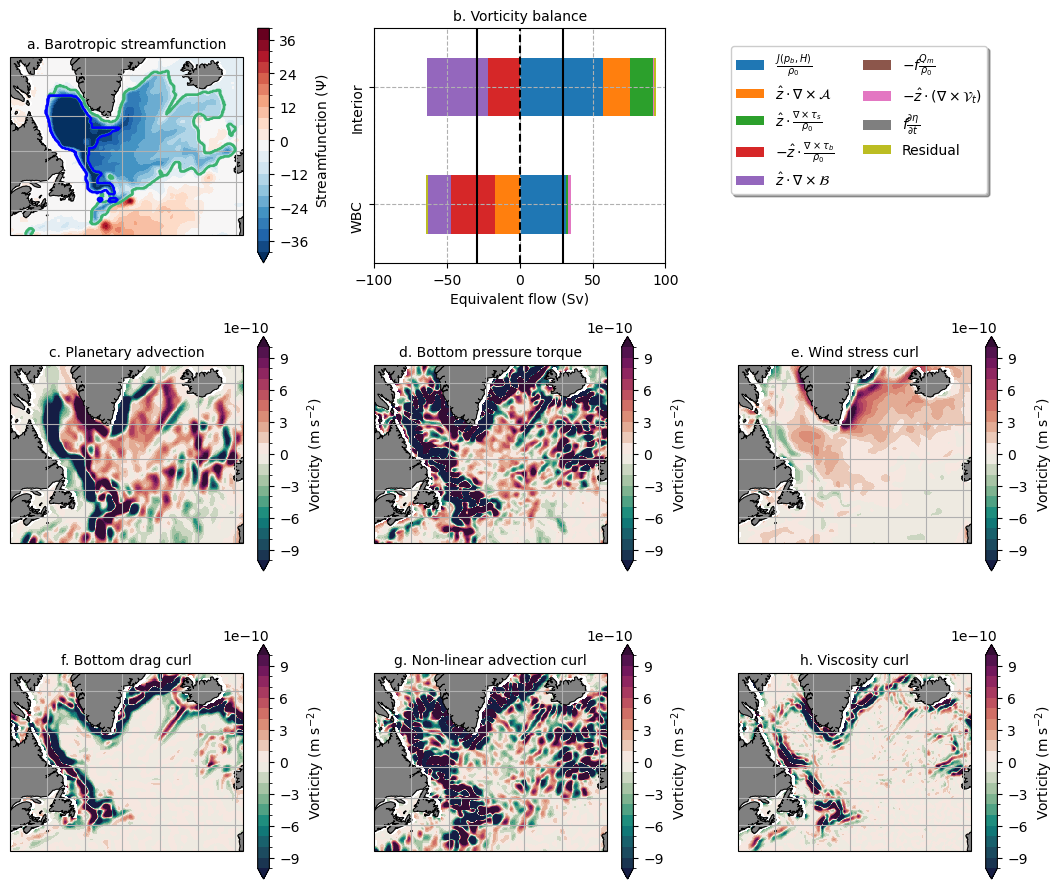

In [71]:
fig = plt.figure()
fig.set_figheight(5 * 1.8)
fig.set_figwidth(6 * 1.8)

projection = ccrs.Mercator(central_longitude = (x_max_subpolar + x_min_subpolar)/2, min_latitude = y_min_subpolar, 
                           max_latitude = y_max_subpolar)
ax1 = plt.subplot2grid(shape = (3, 3), loc = (0, 0), rowspan = 1, colspan = 1, projection = projection)

Ψ_NA = vmo_2d_NA.cumsum('xq')/(1e6 * ρ0)
Ψ_NA_tmean = Ψ_NA.mean('time')
Ψ_NA_tmean = xr.where(np.isnan(vmo_2d_NA.isel(time = 0)), np.nan, Ψ_NA_tmean).rename('Streamfunction ($\Psi$)').load()

land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='gray', linewidth=0.5)
ax1.coastlines(resolution = '50m')
ax1.add_feature(land_50m)
gl = ax1.gridlines(draw_labels = False)

Ψ_NA_tmean.sel(xq = slice(x_min_subpolar, x_max_subpolar)).sel(yq = slice(y_min_subpolar, y_max_subpolar)).plot.contourf(
    ax = ax1, x = 'xq', y = 'yq', cmap = 'RdBu_r', transform = ccrs.PlateCarree(), 
    levels = np.linspace(-40, 40, 21), add_colorbar = True, rasterized = True, zorder = -20)

ax1.contour(eastern_mask_subpolar.xq, eastern_mask_subpolar.yq, eastern_mask_subpolar, transform = ccrs.PlateCarree(), 
            levels = 1, colors = 'mediumseagreen', lw = 0.5)
ax1.contour(western_mask_subpolar.xq, western_mask_subpolar.yq, western_mask_subpolar, transform = ccrs.PlateCarree(), 
            levels = 1, colors = 'blue', lw = 0.5)

ax1.set_title('a. Barotropic streamfunction', fontsize = 10)

ax1 = plt.subplot2grid(shape = (3, 3), loc = (0, 1), rowspan = 1, colspan = 1)

df_subpolar.plot(kind = "barh", stacked = True, ax = ax1)
plt.grid(True, ls = '--')
plt.xlim([-100, 100])
plt.axvline(0, color = 'black', ls = '--')
plt.yticks(rotation = 90)

totals = df_subpolar.sum(axis=1)

plt.axvline(totals.max(), color = 'black')
plt.axvline(totals.min(), color = 'black')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc = 'upper center', bbox_to_anchor = (0.8, 0.95),
          fancybox = True, shadow = True, ncol = 2, fontsize = 10)

ax1.legend().set_visible(False)
ax1.set_title('b. Vorticity balance', fontsize = 10)
ax1.set_xlabel('Equivalent flow (Sv)')

ax1 = plt.subplot2grid(shape = (3, 3), loc = (1, 0), rowspan = 1, colspan = 1, projection = projection)
ax1.coastlines(resolution = '50m')
ax1.add_feature(land_50m)
gl = ax1.gridlines(draw_labels = False)
beta_v.rename('Vorticity (m s$^{-2}$)').plot(ax = ax1, x = 'xq', y = 'yq', cmap = cm.cm.curl, transform = ccrs.PlateCarree(), 
                                 levels = np.linspace(-1e-9, 1e-9, 21), add_colorbar = True, rasterized = True, zorder = -20)
#ax1.contour(eastern_mask_subtropics2.xq, eastern_mask_subtropics2.yq, eastern_mask_subtropics2, transform = ccrs.PlateCarree(), 
#            levels = 1, colors = 'mediumseagreen', lw = 0.5)
#ax1.contour(western_mask_subtropics2.xq, western_mask_subtropics2.yq, western_mask_subtropics2, transform = ccrs.PlateCarree(), 
#            levels = 1, colors = 'blue', lw = 0.5)
ax1.set_title('c. Planetary advection', fontsize = 10)

ax1 = plt.subplot2grid(shape = (3, 3), loc = (1, 1), rowspan = 1, colspan = 1, projection = projection)
ax1.coastlines(resolution = '50m')
ax1.add_feature(land_50m)
gl = ax1.gridlines(draw_labels = False)
BPT.rename('Vorticity (m s$^{-2}$)').plot(ax = ax1, x = 'xq', y = 'yq', cmap = cm.cm.curl, transform = ccrs.PlateCarree(), 
                                 levels = np.linspace(-1e-9, 1e-9, 21), add_colorbar = True, rasterized = True, zorder = -20)
#ax1.contour(eastern_mask_subtropics2.xq, eastern_mask_subtropics2.yq, eastern_mask_subtropics2, transform = ccrs.PlateCarree(), 
#            levels = 1, colors = 'mediumseagreen', lw = 0.5)
#ax1.contour(western_mask_subtropics2.xq, western_mask_subtropics2.yq, western_mask_subtropics2, transform = ccrs.PlateCarree(), 
#            levels = 1, colors = 'blue', lw = 0.5)
ax1.set_title('d. Bottom pressure torque', fontsize = 10)

ax1 = plt.subplot2grid(shape = (3, 3), loc = (1, 2), rowspan = 1, colspan = 1, projection = projection)
ax1.coastlines(resolution = '50m')
ax1.add_feature(land_50m)
gl = ax1.gridlines(draw_labels = False)
curl_taus.rename('Vorticity (m s$^{-2}$)').plot(ax = ax1, x = 'xq', y = 'yq', cmap = cm.cm.curl, transform = ccrs.PlateCarree(), 
                                 levels = np.linspace(-1e-9, 1e-9, 21), add_colorbar = True, rasterized = True, zorder = -20)
#ax1.contour(eastern_mask_subtropics2.xq, eastern_mask_subtropics2.yq, eastern_mask_subtropics2, transform = ccrs.PlateCarree(), 
#            levels = 1, colors = 'mediumseagreen', lw = 0.5)
#ax1.contour(western_mask_subtropics2.xq, western_mask_subtropics2.yq, western_mask_subtropics2, transform = ccrs.PlateCarree(), 
#            levels = 1, colors = 'blue', lw = 0.5)
ax1.set_title('e. Wind stress curl', fontsize = 10)

ax1 = plt.subplot2grid(shape = (3, 3), loc = (2, 0), rowspan = 1, colspan = 1, projection = projection)
ax1.coastlines(resolution = '50m')
ax1.add_feature(land_50m)
gl = ax1.gridlines(draw_labels = False)
curl_taub.rename('Vorticity (m s$^{-2}$)').plot(ax = ax1, x = 'xq', y = 'yq', cmap = cm.cm.curl, transform = ccrs.PlateCarree(), 
                                 levels = np.linspace(-1e-9, 1e-9, 21), add_colorbar = True, rasterized = True, zorder = -20)
#ax1.contour(eastern_mask_subtropics2.xq, eastern_mask_subtropics2.yq, eastern_mask_subtropics2, transform = ccrs.PlateCarree(), 
#            levels = 1, colors = 'mediumseagreen', lw = 0.5)
#ax1.contour(western_mask_subtropics2.xq, western_mask_subtropics2.yq, western_mask_subtropics2, transform = ccrs.PlateCarree(), 
#            levels = 1, colors = 'blue', lw = 0.5)
ax1.set_title('f. Bottom drag curl', fontsize = 10)

ax1 = plt.subplot2grid(shape = (3, 3), loc = (2, 1), rowspan = 1, colspan = 1, projection = projection)
ax1.coastlines(resolution = '50m')
ax1.add_feature(land_50m)
gl = ax1.gridlines(draw_labels = False)
curl_NL.rename('Vorticity (m s$^{-2}$)').plot(ax = ax1, x = 'xq', y = 'yq', cmap = cm.cm.curl, transform = ccrs.PlateCarree(), 
                                 levels = np.linspace(-1e-9, 1e-9, 21), add_colorbar = True, rasterized = True, zorder = -20)
#ax1.contour(eastern_mask_subtropics2.xq, eastern_mask_subtropics2.yq, eastern_mask_subtropics2, transform = ccrs.PlateCarree(), 
#            levels = 1, colors = 'mediumseagreen', lw = 0.5)
#ax1.contour(western_mask_subtropics2.xq, western_mask_subtropics2.yq, western_mask_subtropics2, transform = ccrs.PlateCarree(), 
#            levels = 1, colors = 'blue', lw = 0.5)
ax1.set_title('g. Non-linear advection curl', fontsize = 10)

ax1 = plt.subplot2grid(shape = (3, 3), loc = (2, 2), rowspan = 1, colspan = 1, projection = projection)
ax1.coastlines(resolution = '50m')
ax1.add_feature(land_50m)
gl = ax1.gridlines(draw_labels = False)
curl_diff.rename('Vorticity (m s$^{-2}$)').plot(ax = ax1, x = 'xq', y = 'yq', cmap = cm.cm.curl, transform = ccrs.PlateCarree(), 
                                 levels = np.linspace(-1e-9, 1e-9, 21), add_colorbar = True, rasterized = True, zorder = -20)
#ax1.contour(eastern_mask_subtropics2.xq, eastern_mask_subtropics2.yq, eastern_mask_subtropics2, transform = ccrs.PlateCarree(), 
#            levels = 1, colors = 'mediumseagreen', lw = 0.5)
#ax1.contour(western_mask_subtropics2.xq, western_mask_subtropics2.yq, western_mask_subtropics2, transform = ccrs.PlateCarree(), 
#            levels = 1, colors = 'blue', lw = 0.5)
ax1.set_title('h. Viscosity curl', fontsize = 10)

fig.tight_layout()

plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/Draft_figures/Control-budget-subpolar.pdf', bbox_inches = 'tight', 
            dpi = 300, transparent=True)

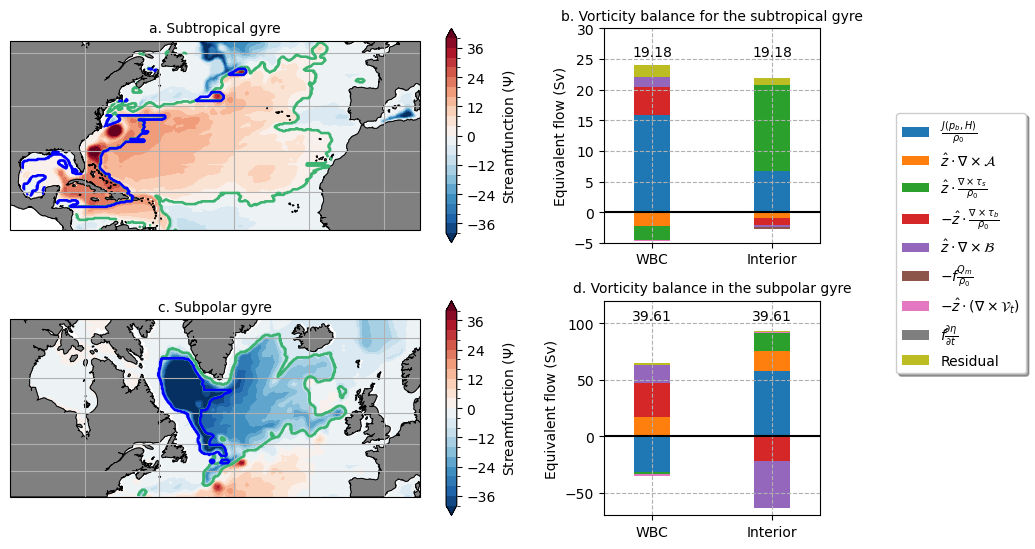

In [ ]:
ax1 = plt.subplot2grid(shape = (2, 3), loc = (0, 2), rowspan = 1, colspan = 1)

df_subtropics.plot(kind = "bar", stacked = True, width = 0.3, ax = ax1)
plt.grid(True, ls = '--')
plt.ylim([-5, 30])
plt.axhline(0, color = 'black')
plt.xticks(rotation = 0)

totals = df_subtropics.sum(axis=1)

# Add the sum as text at the top of each bar
for i, total in enumerate(totals):
    plt.text(i, 25, str(round(total, 2)), ha='center', va='bottom')

ax1.legend().set_visible(True)
ax1.set_title('b. Vorticity balance for the subtropical gyre', fontsize = 10)
ax1.set_ylabel('Equivalent flow (Sv)')

#handles, labels = ax1.get_legend_handles_labels()
#fig.legend(handles, labels, loc = 'upper center', bbox_to_anchor = (1.15, 0.8),
#          fancybox = True, shadow = True, ncol = 1, fontsize = 10)

projection = ccrs.Mercator(central_longitude = (x_max_subpolar + x_min_subpolar)/2, min_latitude = y_min_subpolar, 
                           max_latitude = y_max_subpolar)
ax1 = plt.subplot2grid(shape = (2, 3), loc = (1, 0), rowspan = 1, colspan = 2, projection = projection)

land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='gray', linewidth=0.5)
ax1.coastlines(resolution = '50m')
ax1.add_feature(land_50m)
gl = ax1.gridlines(draw_labels = False)

Ψ_NA_tmean.plot.contourf(ax = ax1, x = 'xq', y = 'yq', cmap = 'RdBu_r', transform = ccrs.PlateCarree(), 
                         levels = np.linspace(-40, 40, 21), add_colorbar = True, rasterized = True, zorder = -20)

ax1.contour(eastern_mask_subpolar.xq, eastern_mask_subpolar.yq, eastern_mask_subpolar, transform = ccrs.PlateCarree(), 
            levels = 1, colors = 'mediumseagreen', lw = 0.5)
ax1.contour(western_mask_subpolar.xq, western_mask_subpolar.yq, western_mask_subpolar, transform = ccrs.PlateCarree(), 
            levels = 1, colors = 'blue', lw = 0.5)

ax1.set_title('c. Subpolar gyre', fontsize = 10)

ax1 = plt.subplot2grid(shape = (2, 3), loc = (1, 2), rowspan = 1, colspan = 1)

df_subpolar.plot(kind = "bar", stacked = True, width = 0.3, ax = ax1)
plt.grid(True, ls = '--')
plt.ylim([-70, 120])
plt.axhline(0, color = 'black')
plt.xticks(rotation = 0)

totals = df_subpolar.sum(axis=1)

# Add the sum as text at the top of each bar
for i, total in enumerate(totals):
    plt.text(i, 100, str(round(total + abs(cutoff_contour), 2)), ha='center', va='bottom')

ax1.legend().set_visible(False)
ax1.set_title('d. Vorticity balance in the subpolar gyre', fontsize = 10)
ax1.set_ylabel('Equivalent flow (Sv)')
fig.tight_layout()

#plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/Draft_figures/Control-budget.pdf', bbox_inches = 'tight', 
#            dpi = 300, transparent=True)